# Teletext key figures
Earliest and latest entries, monthly volume, and rubric distribution.

In [3]:
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt

from modules.document_retriever import DB_HOST, DB_PORT, DB_NAME, DB_USER, DB_PASSWORD
from modules.notebook_helpers import display_search_results

%matplotlib inline

def get_conn():
    return psycopg2.connect(
        host=DB_HOST,
        port=DB_PORT,
        dbname=DB_NAME,
        user=DB_USER,
        password=DB_PASSWORD,
    )


## Number of entries

In [4]:
sql = """
    select count(*) FROM docs_teletext;
"""

with get_conn() as conn:
    with conn.cursor() as cur:
        cur.execute(sql)
        rows = cur.fetchone()

print(f"Total number of entries: {rows[0]}")



Total number of entries: 550139


## Earliest and latest entries

In [5]:
sql = """
    (SELECT teletext_id, title, content, publication_datetime
     FROM docs_teletext
     WHERE publication_datetime IS NOT NULL
     ORDER BY publication_datetime ASC
     LIMIT 1)
    UNION ALL
    (SELECT teletext_id, title, content, publication_datetime
     FROM docs_teletext
     WHERE publication_datetime IS NOT NULL
     ORDER BY publication_datetime DESC
     LIMIT 1)
"""

with get_conn() as conn:
    with conn.cursor() as cur:
        cur.execute(sql)
        rows = cur.fetchall()

if not rows:
    print("No rows with publication_datetime found.")
else:
    results = []
    for teletext_id, title, content, publication_datetime in rows:
        results.append(
            {
                "teletext_id": teletext_id,
                "chunk_id": None,
                "chunk_text": None,
                "title": title,
                "content": content,
                "publication_datetime": publication_datetime,
                "fts_score": None,
                "cosine_similarity": None,
                "cross_score": None,
            }
        )

    display_search_results(results, max_content_chars=600)


## Entries per month

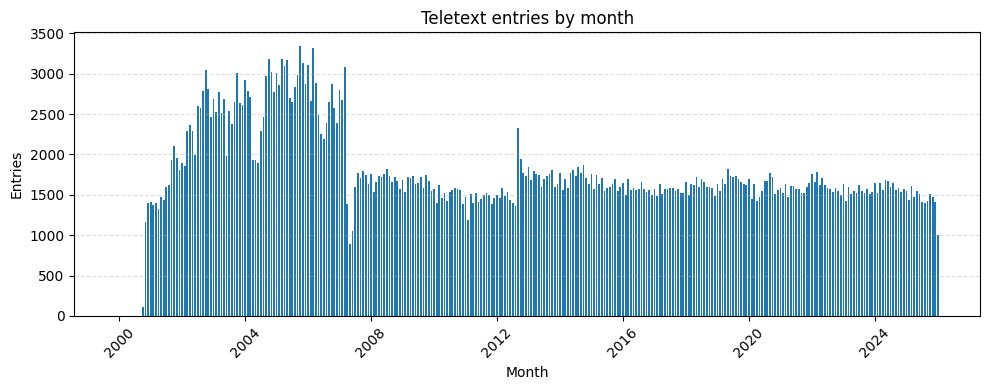

In [6]:
sql = """
    SELECT date_trunc('month', publication_datetime) AS month,
           COUNT(*) AS entry_count
    FROM docs_teletext
    WHERE publication_datetime IS NOT NULL
    GROUP BY 1
    ORDER BY 1
"""

with get_conn() as conn:
    df_month = pd.read_sql(sql, conn)

if df_month.empty:
    print("No rows with publication_datetime found.")
else:
    df_month["month"] = pd.to_datetime(df_month["month"])

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(df_month["month"], df_month["entry_count"], width=20)
    ax.set_title("Teletext entries by month")
    ax.set_xlabel("Month")
    ax.set_ylabel("Entries")
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## Topics

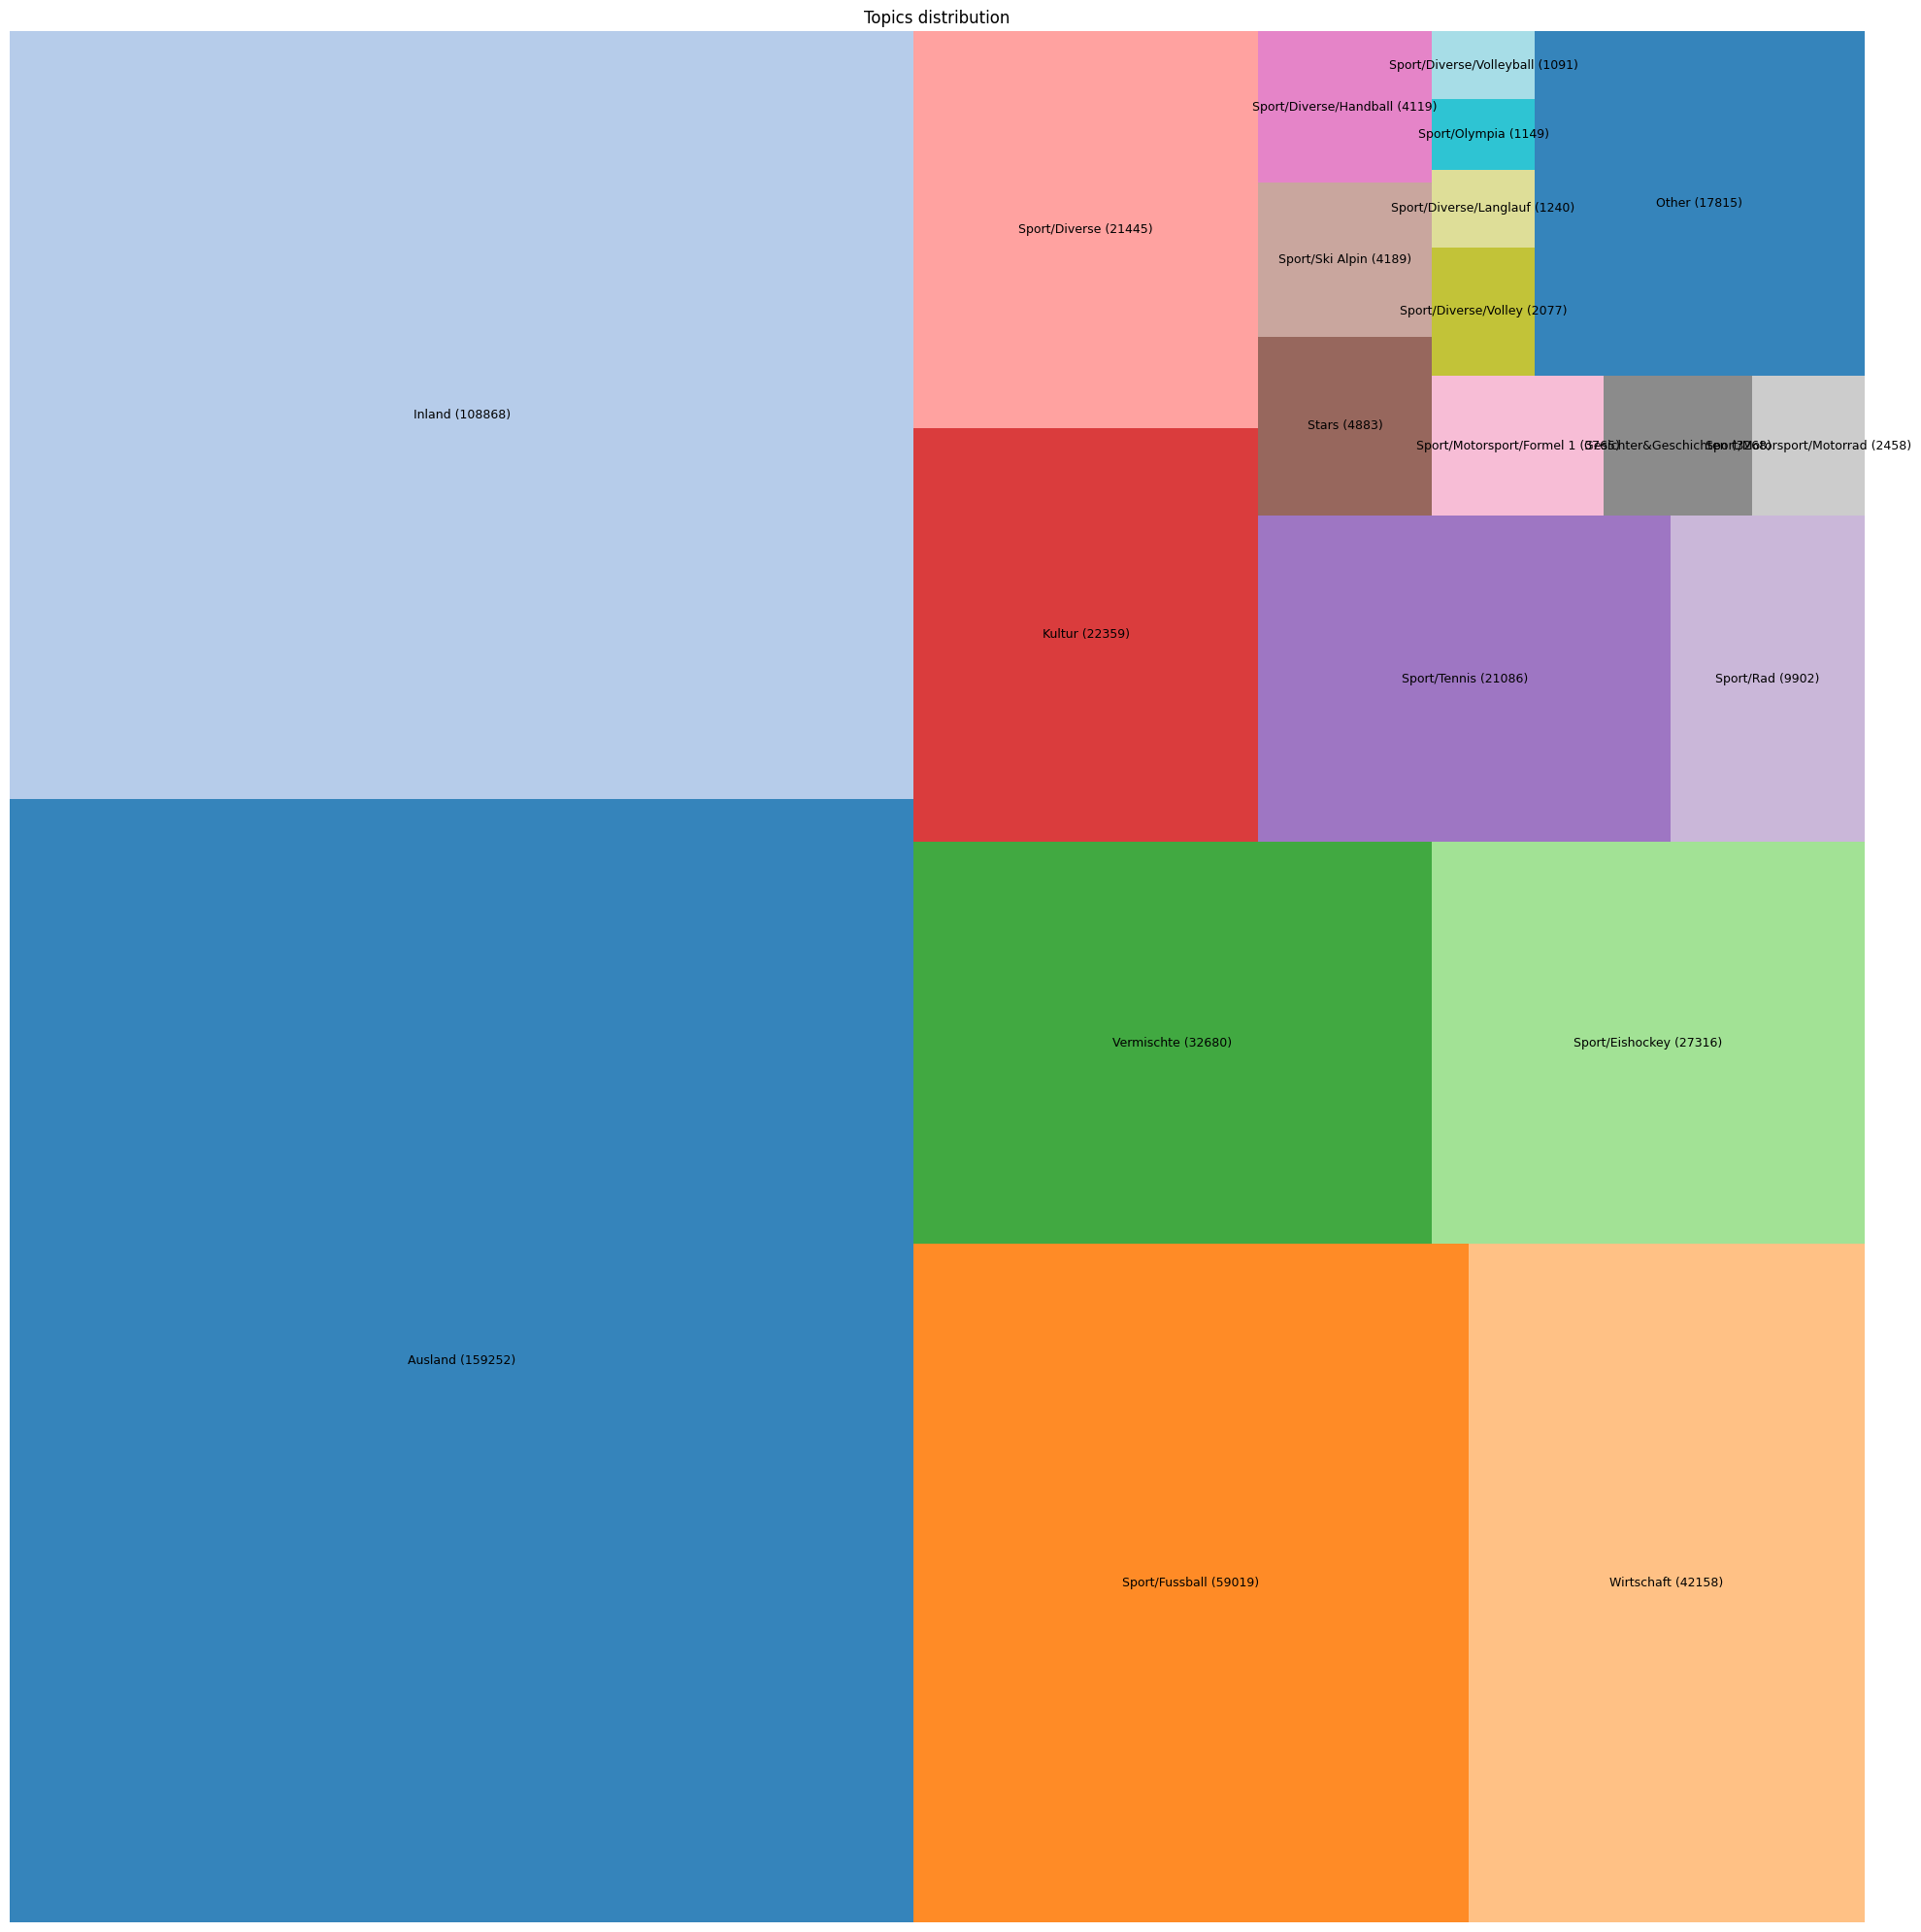

In [7]:
import squarify

sql = """
    SELECT COALESCE(rubric, 'Unknown') AS rubric, COUNT(*) AS entry_count
    FROM docs_teletext
    GROUP BY 1
    ORDER BY 2 DESC
"""

with get_conn() as conn:
    df_rubric = pd.read_sql(sql, conn)

top_n = 20
if len(df_rubric) > top_n:
    df_top = df_rubric.head(top_n).copy()
    other_count = df_rubric.iloc[top_n:]["entry_count"].sum()
    df_top.loc[len(df_top)] = {"rubric": "Other", "entry_count": other_count}
else:
    df_top = df_rubric.copy()

counts = df_top["entry_count"].to_numpy()
labels = df_top["rubric"].tolist()

fig, ax = plt.subplots(figsize=(20, 20))
palette = plt.cm.tab20(np.linspace(0, 1, 20))
colors = [palette[i % 20] for i in range(len(labels))]
squarify.plot(
    sizes=counts,
    label=[f"{label} ({count})" for label, count in zip(labels, counts)],
    color=colors,
    alpha=0.9,
    ax=ax,
    text_kwargs={"fontsize": 9},
)
ax.set_title("Topics distribution")
ax.axis("off")
plt.tight_layout()
plt.show()
